# Use TTH_Template Custom Notebook template

In [1]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

pd.options.display.max_columns = 50
warnings.filterwarnings("ignore")

from fosforml.model_manager.snowflakesession import get_session
from fosforml import register_model

# Read data from Snowflake

In [2]:
my_session = get_session()

In [3]:
table_name = 'FLIGHTS'

sf_df = my_session.sql("select * from {}".format(table_name))
df = sf_df.to_pandas()

In [4]:
flights = df.copy()
flights_needed_data = df.copy()

In [5]:
flights_needed_data

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE__CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT_CODE,DESTINATION_AIRPORT_CODE,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,2,12,4,WN,697,N399WN,BWI,CLT,840,910.0,30.0,13.0,923.0,95.0,90.0,73.0,361,1036.0,4.0,1015,1040.0,25.0,0,0,None,0.0,0.0,12.0,13.0,0.0
1,2015,2,12,4,WN,523,N232WN,BWI,MCI,840,839.0,-1.0,14.0,853.0,185.0,164.0,146.0,967,1019.0,4.0,1045,1023.0,-22.0,0,0,None,NaN,NaN,NaN,NaN,NaN
2,2015,2,12,4,WN,2513,N8600F,BWI,RSW,840,909.0,29.0,17.0,926.0,175.0,160.0,139.0,919,1145.0,4.0,1135,1149.0,14.0,0,0,None,NaN,NaN,NaN,NaN,NaN
3,2015,2,12,4,WN,451,N8647A,BWI,SJU,840,840.0,0.0,36.0,916.0,255.0,260.0,219.0,1565,1355.0,5.0,1355,1400.0,5.0,0,0,None,NaN,NaN,NaN,NaN,NaN
4,2015,2,12,4,WN,3497,N441WN,SFO,ATL,840,839.0,-1.0,9.0,848.0,270.0,275.0,261.0,2139,1609.0,5.0,1610,1614.0,4.0,0,0,None,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819074,2015,8,26,3,EV,4993,N717EV,ORF,DTW,1430,1425.0,-5.0,10.0,1435.0,114.0,113.0,95.0,529,1610.0,8.0,1624,1618.0,-6.0,0,0,None,NaN,NaN,NaN,NaN,NaN
5819075,2015,8,26,3,EV,4926,N138EV,PHF,ATL,1430,1427.0,-3.0,9.0,1436.0,106.0,101.0,87.0,508,1603.0,5.0,1616,1608.0,-8.0,0,0,None,NaN,NaN,NaN,NaN,NaN
5819076,2015,8,26,3,EV,5092,N582CA,HOU,ATL,1430,1426.0,-4.0,10.0,1436.0,119.0,106.0,91.0,696,1707.0,5.0,1729,1712.0,-17.0,0,0,None,NaN,NaN,NaN,NaN,NaN
5819077,2015,8,26,3,EV,6037,N14570,IAH,AMA,1430,1427.0,-3.0,11.0,1438.0,106.0,103.0,80.0,517,1558.0,12.0,1616,1610.0,-6.0,0,0,None,NaN,NaN,NaN,NaN,NaN


In [6]:
flights_needed_data.value_counts('DIVERTED')  # will tell us the no. of flights which were diverted

DIVERTED
0    5803892
1      15187
Name: count, dtype: int64

In [7]:
# filtering out unnecessary columns
flights_needed_data=flights_needed_data.drop(['YEAR','FLIGHT_NUMBER','AIRLINE__CODE','DISTANCE','TAIL_NUMBER','TAXI_OUT',
                                              'SCHEDULED_TIME','DEPARTURE_TIME','WHEELS_OFF','ELAPSED_TIME',
                                              'AIR_TIME','WHEELS_ON','DAY_OF_WEEK','TAXI_IN','CANCELLATION_REASON'],
                                             axis=1)

In [ ]:
# replacing all NaN values with the mean of the attribute in which they are present
flights_needed_data=flights_needed_data.fillna(flights_needed_data.mean())

In [ ]:
flights_needed_data.head()

In [ ]:
# creating a new column; it will tell if the flight was delayed or not
reslt=[]

In [ ]:
for row in flights_needed_data['ARRIVAL_DELAY']:
  if row > 15:
    result.append(1)
  else:
    result.append(0) 

In [ ]:
flights_needed_data['result'] = result

In [ ]:
flights_needed_data.value_counts('result')

In [ ]:
# removing some more columns
flights_needed_data=flights_needed_data.drop(['ORIGIN_AIRPORT_CODE', 'DESTINATION_AIRPORT_CODE', 'ARRIVAL_TIME', 'ARRIVAL_DELAY'],axis=1)
flights_needed_data

In [ ]:
data = flights_needed_data.values
X, y = data[:,:-1], data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)  # splitting in the ratio 70:30

In [ ]:
scaled_features = StandardScaler().fit_transform(X_train, X_test)

In [ ]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)

In [ ]:
pred_prob = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, pred_prob[:,1])
auc_score

#### Given the large size of the dataset, I decide to consider only a subset of the data in order to reduce the computational time

In [178]:
df = df[df['MONTH'] == 1]

In [179]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])

#### The SCHEDULED_DEPARTURE variable, the hour of the take-off is coded as a float where the two first digits indicate the hour and the two last, the minutes. This format is not convenient and I thus convert it. Finally, I merge the take-off hour with the flight date. To proceed with these transformations

In [180]:
#_________________________________________________________
# Function that convert the 'HHMM' string to datetime.time
def format_heure(chaine):
    if pd.isnull(chaine):
        return np.nan
    else:
        if (chaine == 2400 or chaine == '2400') : chaine = '0000'
        #chaine = "{0:04d}".format(int(chaine))
        #print (chaine)
        heure = datetime.time(int(chaine[0:2]), int(chaine[2:4]))
        return heure
#_____________________________________________________________________
# Function that combines a date and time to produce a datetime.datetime
def combine_date_heure(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
#_______________________________________________________________________________
# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows(): 
        print ("1 -> ", cols['DATE'], "----",cols['SCHEDULED_DEPARTURE'])
        if pd.isnull(cols['SCHEDULED_DEPARTURE']):
            print ("2 -> Null")
            liste.append(np.nan)
        elif (float(cols['SCHEDULED_DEPARTURE']) == 2400 or float(cols['SCHEDULED_DEPARTURE']) == '2400'):
            cols['DATE'] += datetime.timedelta(days=1)
            cols['SCHEDULED_DEPARTURE'] = datetime.time(0,0)
            print ("3 -> ", cols['DATE'], "----",cols['SCHEDULED_DEPARTURE'])
            liste.append(combine_date_heure(cols))
        else:
            cols['SCHEDULED_DEPARTURE'] = format_heure(cols['SCHEDULED_DEPARTURE'])
            print ("4 -> ", cols['DATE'], cols['SCHEDULED_DEPARTURE'])
            liste.append(combine_date_heure(cols))
    return pd.Series(liste)

In [181]:
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
                       'MONTH','DAY','DAY_OF_WEEK', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
df.drop(variables_to_remove, axis = 1, inplace = True)

In [182]:
df = df[['DATE','AIRLINE__CODE', 'ORIGIN_AIRPORT_CODE', 'DESTINATION_AIRPORT_CODE',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]

In [183]:
df.dropna(inplace=True)

In [184]:
df['SCHEDULED_DEPARTURE'] = df['SCHEDULED_DEPARTURE'].astype(str).str.zfill(4)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].astype(str).str.zfill(4)
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].astype(int).astype(str).str.zfill(4)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].astype(int).astype(str).str.zfill(4)

In [185]:
df['SCHEDULED_DEPARTURE'] = df['SCHEDULED_DEPARTURE'].apply(format_heure)
df['DATE'] = df['DATE'].astype(str)
df['SCHEDULED_DEPARTURE'] = df['SCHEDULED_DEPARTURE'].astype(str)
df['SCHEDULED_DEPARTURE'] = pd.to_datetime(df['DATE']+ ' ' + df['SCHEDULED_DEPARTURE'])

In [186]:
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_heure)

In [187]:
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_heure)

In [188]:
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_heure)

In [189]:
variables_to_remove = ['DATE']
df.drop(variables_to_remove, axis = 1, inplace = True)

In [190]:
df.dropna(inplace = True)

In [38]:
df.columns

Index(['AIRLINE__CODE', 'ORIGIN_AIRPORT_CODE', 'DESTINATION_AIRPORT_CODE',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'SCHEDULED_TIME',
       'ELAPSED_TIME'],
      dtype='object')

# Model Training

In [191]:
df_train = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) < datetime.date(2015, 1, 23)]
df_test  = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) > datetime.date(2015, 1, 23)]
df = df_train

In [192]:
df_train.shape, df_test.shape

((329515, 11), (111573, 11))

In [193]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 329515 entries, 4472832 to 4809026
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   AIRLINE__CODE             329515 non-null  object        
 1   ORIGIN_AIRPORT_CODE       329515 non-null  object        
 2   DESTINATION_AIRPORT_CODE  329515 non-null  object        
 3   SCHEDULED_DEPARTURE       329515 non-null  datetime64[ns]
 4   DEPARTURE_TIME            329515 non-null  object        
 5   DEPARTURE_DELAY           329515 non-null  float64       
 6   SCHEDULED_ARRIVAL         329515 non-null  object        
 7   ARRIVAL_TIME              329515 non-null  object        
 8   ARRIVAL_DELAY             329515 non-null  float64       
 9   SCHEDULED_TIME            329515 non-null  float64       
 10  ELAPSED_TIME              329515 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(6)
memory usage: 30.2+

# Model nº1: one airline, one airport

In [196]:
def get_flight_delays(df, carrier, id_airport, extrem_values = False):
    df2 = df[(df['AIRLINE__CODE'] == carrier) & (df['ORIGIN_AIRPORT_CODE'] == id_airport)]
    #_______________________________________
    # remove extreme values before fitting
    if extrem_values:
        df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
        df2.dropna(how = 'any')
    #__________________________________
    # Conversion: date + heure -> heure
    df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
    df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    #___________________________________________________________________
    # regroupement des vols par heure de départ et calcul de la moyenne
    test2 = df2['DEPARTURE_DELAY'].groupby(df2['heure_depart']).apply(get_stats).unstack()
    test2.reset_index(inplace=True)
    #___________________________________
    # conversion de l'heure en secondes
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    test2.reset_index(inplace=True)
    test2['heure_depart_min'] = test2['heure_depart'].apply(fct)
    return test2

In [197]:
def linear_regression(test2):
    test = test2[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
    X = np.array(test['heure_depart_min'])
    Y = np.array(test['mean'])
    X = X.reshape(len(X),1)
    Y = Y.reshape(len(Y),1)
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    result = regr.predict(X)
    return X, Y, result

In [104]:
id_airport = 'PHL'
df2 = df[(df['AIRLINE__CODE'] == carrier) & (df['ORIGIN_AIRPORT_CODE'] == id_airport)]
df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
df2['heure_depart'] = df2['heure_depart'].apply(lambda x:x.hour*3600+x.minute*60+x.second)
#___________________
# first case
test2 = get_flight_delays(df, carrier, id_airport, False)
X1, Y1, result2 = linear_regression(test2)
#___________________
# second case
test3 = get_flight_delays(df, carrier, id_airport, True)
X2, Y2, result3 = linear_regression(test3)

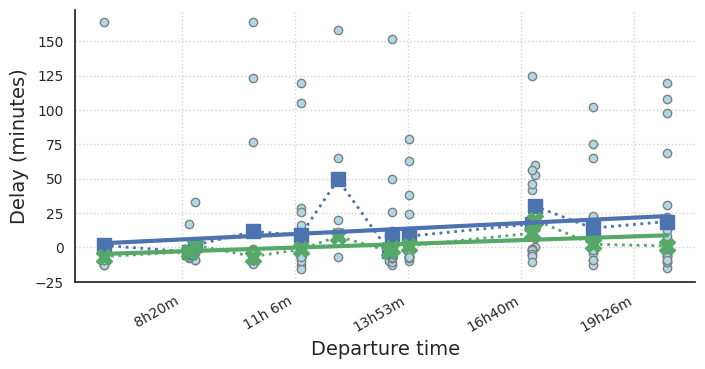

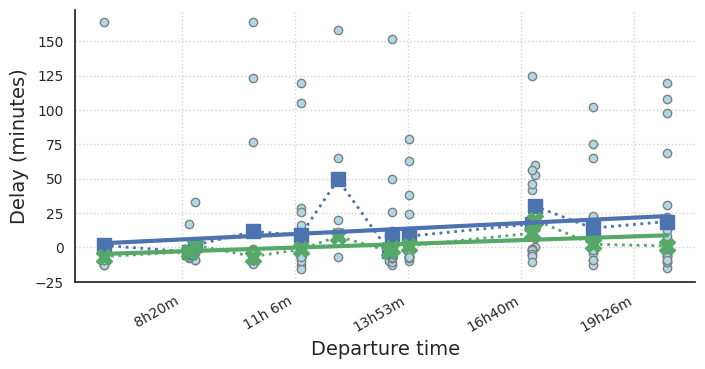

In [106]:
fig1 = Figure_style(8, 4, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_scatter(df2['heure_depart'], df2['DEPARTURE_DELAY'], markeredge = True)
fig1.cust_plot(X1, Y1, color = 'b', linestyle = ':', linewidth = 2, marker = ('b','s', 10))
fig1.cust_plot(X2, Y2, color = 'g', linestyle = ':', linewidth = 2, marker = ('g','X', 12))
fig1.cust_plot(X1, result2, color = 'b', linewidth = 3)
fig1.cust_plot(X2, result3, color = 'g', linewidth = 3)
fig1.style()
fig1.set_ylabel('Delay (minutes)', fontsize = 14)
fig1.set_xlabel('Departure time', fontsize = 14)
#____________________________________
# convert and set the x ticks labels
fct_convert = lambda x: (int(x/3600) , int(divmod(x,3600)[1]/60))
fig1.axs[fig1.ix, fig1.iy].set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*fct_convert(x))
                                            for x in fig1.axs[fig1.ix, fig1.iy].get_xticks()]);
plt.show()

In [108]:
class fit_polynome:

    def __init__(self, data):
        self.data = data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)

    def split(self, method):        
        self.method = method        
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

        if method == 'all':
            self.X_train = self.X
            self.Y_train = self.Y
            self.X_test  = self.X
            self.Y_test  = self.Y                        
        elif method == 'split':            
            self.X_train, self.X_test, self.Y_train, self.Y_test = \
                train_test_split(self.X, self.Y, test_size=0.3)
    
    def train(self, pol_order):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X_train)
        self.regr.fit(self.X_, self.Y_train)
    
    def predict(self, X):
        self.X_ = self.poly.fit_transform(X)
        self.result = self.regr.predict(self.X_)
    
    def calc_score(self):        
        X_ = self.poly.fit_transform(self.X_test)
        result = self.regr.predict(X_)
        self.score = metrics.mean_squared_error(result, self.Y_test)


findfont: Generic family 'fantasy' not found because none of the following families were found: Chicago, Charcoal, Impact, Western, Humor Sans, xkcd, fantasy
findfont: Generic family 'fantasy' not found because none of the following families were found: Chicago, Charcoal, Impact, Western, Humor Sans, xkcd, fantasy
findfont: Generic family 'fantasy' not found because none of the following families were found: Chicago, Charcoal, Impact, Western, Humor Sans, xkcd, fantasy
findfont: Generic family 'fantasy' not found because none of the following families were found: Chicago, Charcoal, Impact, Western, Humor Sans, xkcd, fantasy
findfont: Generic family 'fantasy' not found because none of the following families were found: Chicago, Charcoal, Impact, Western, Humor Sans, xkcd, fantasy


modèle nº1 , min. pour n = 3, score = 37.2
modèle nº2 , min. pour n = 1, score = 142.0
modèle nº3 , min. pour n = 1, score = 44.7
modèle nº4 , min. pour n = 1, score = 41.1
modèle nº5 , min. pour n = 2, score = 227.8


findfont: Generic family 'fantasy' not found because none of the following families were found: Chicago, Charcoal, Impact, Western, Humor Sans, xkcd, fantasy
findfont: Generic family 'fantasy' not found because none of the following families were found: Chicago, Charcoal, Impact, Western, Humor Sans, xkcd, fantasy
findfont: Generic family 'fantasy' not found because none of the following families were found: Chicago, Charcoal, Impact, Western, Humor Sans, xkcd, fantasy
findfont: Generic family 'fantasy' not found because none of the following families were found: Chicago, Charcoal, Impact, Western, Humor Sans, xkcd, fantasy
findfont: Generic family 'fantasy' not found because none of the following families were found: Chicago, Charcoal, Impact, Western, Humor Sans, xkcd, fantasy
findfont: Generic family 'fantasy' not found because none of the following families were found: Chicago, Charcoal, Impact, Western, Humor Sans, xkcd, fantasy
findfont: Generic family 'fantasy' not found because

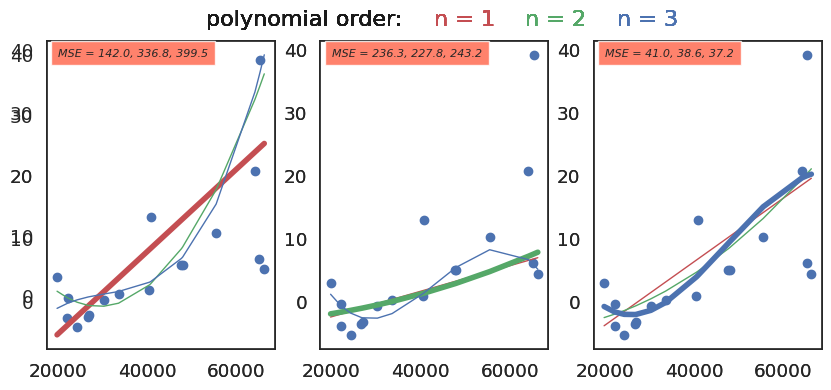

In [110]:
fig = plt.figure(1, figsize=(10,4))

ax = ['_' for _ in range(4)]
ax[1]=fig.add_subplot(131) 
ax[2]=fig.add_subplot(132) 
ax[3]=fig.add_subplot(133) 

id_airport = 'BNA'
test2 = get_flight_delays(df, carrier, id_airport, True)

result = ['_' for _ in range(4)]
score = [10000 for _ in range(4)]
found = [False for _ in range(4)]
fit = fit_polynome(test2)

color = '.rgbyc'

inc = 0
while True:
    inc += 1
    fit.split('split')
    for i in range(1,4):
        fit.train(pol_order = i)
        fit.predict(fit.X)
        result[i] = fit.result
        fit.calc_score()
        score[i]  = fit.score

    [ind_min] = [j for j,val in enumerate(score) if min(score) == val]
    print("modèle nº{:<2}, min. pour n = {}, score = {:.1f}".format(inc, ind_min,score[ind_min]))
    
    if not found[ind_min]:            
        for i in range(1,4):
            ax[ind_min].plot(fit.X, result[i], color[i], linewidth = 4 if i == ind_min else 1)
        ax[ind_min].scatter(fit.X, fit.Y)                
        ax[ind_min].text(0.05, 0.95, 'MSE = {:.1f}, {:.1f}, {:.1f}'.format(*score[1:4]),
                         style='italic', transform=ax[ind_min].transAxes, fontsize = 8,
                         bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})                
        found[ind_min] = True

    shift = 0.5
    plt.text(-1+shift, 1.05, "polynomial order:", color = 'k',
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0+shift, 1.05, "n = 1", color = 'r', 
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0.4+shift, 1.05, "n = 2", color = 'g', 
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0.8+shift, 1.05, "n = 3", color = 'b',
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
   
    if inc == 40 or all(found[1:4]): break
plt.show()

In [113]:
class fit_polynome_cv:

    def __init__(self, data):
        self.data = data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['mean'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

    def train(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.result = cross_val_predict(self.regr, self.X_, self.Y, cv = nb_folds)
    
    def calc_score(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.score = np.mean(cross_val_score(self.regr, self.X_, self.Y,
                                             cv = nb_folds, scoring = 'neg_mean_squared_error'))

In [114]:
#id_airport = 1129804 
nb_folds = 10
print('Max possible number of folds: {} \n'.format(test2.shape[0]-1))
fit2 = fit_polynome_cv(test2)
for i in range(1, 8):
    fit2.calc_score(i, nb_folds)
    print('n={} -> MSE = {}'.format(i, round(abs(fit2.score),3)))

Max possible number of folds: 16 

n=1 -> MSE = 130.629
n=2 -> MSE = 151.79
n=3 -> MSE = 159.455
n=4 -> MSE = 162.631
n=5 -> MSE = 166.966
n=6 -> MSE = 173.08
n=7 -> MSE = 181.361


In [115]:
fit = fit_polynome(test2)
fit.split('all')
fit.train(pol_order = 2)
fit.predict(fit.X)

In [116]:
fit2.train(pol_order = 2, nb_folds = nb_folds)

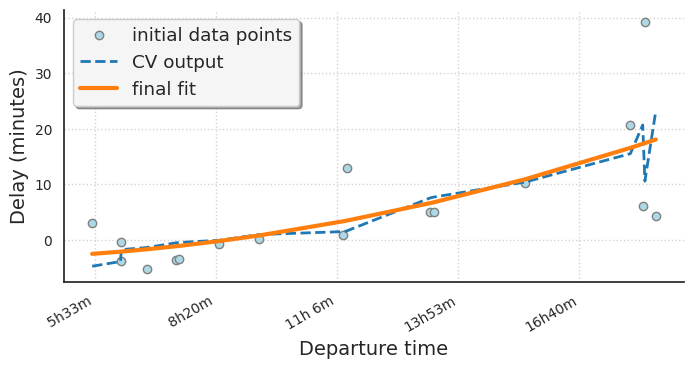

In [117]:
fig1 = Figure_style(8, 4, 1, 1) ; fig1.pos_update(0, 0)
fig1.cust_scatter(fit2.X, fit2.Y, markeredge = True, label = 'initial data points')
fig1.cust_plot(fit.X,fit2.result,color=u'#1f77b4',linestyle='--',linewidth=2,label='CV output')
fig1.cust_plot(fit.X,fit.result,color=u'#ff7f0e',linewidth = 3,label='final fit')
fig1.style(); fig1.draw_legend('upper left')
fig1.set_ylabel('Delay (minutes)') ; fig1.set_xlabel('Departure time')
#____________________________________
# convert and set the x ticks labels
fct_convert = lambda x: (int(x/3600) , int(divmod(x,3600)[1]/60))
fig1.axs[fig1.ix, fig1.iy].set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*fct_convert(x))
                                            for x in fig1.axs[fig1.ix, fig1.iy].get_xticks()]);
plt.show()

In [118]:
score = metrics.mean_squared_error(fit.result, fit2.Y)
score

56.86284771892095

In [119]:
test_data = get_flight_delays(df_test, carrier, id_airport, True)
test_data = test_data[['mean', 'heure_depart_min']].dropna(how='any', axis = 0)
X_test = np.array(test_data['heure_depart_min'])
Y_test = np.array(test_data['mean'])
X_test = X_test.reshape(len(X_test),1)
Y_test = Y_test.reshape(len(Y_test),1)
fit.predict(X_test)

In [120]:
score = metrics.mean_squared_error(fit.result, Y_test)
score

108.67130851577079

In [121]:
'Ecart = {:.2f} min'.format(np.sqrt(score))

'Ecart = 10.42 min'

# Model nº2: One airline, all airports

In [124]:
def get_merged_delays(df, carrier):
    liste_airports = df[df['AIRLINE__CODE'] == carrier]['ORIGIN_AIRPORT_CODE'].unique()
    i = 0
    liste_columns = ['AIRPORT__CODE', 'heure_depart_min', 'mean']
    for id_airport in liste_airports:
        test2 = get_flight_delays(df, carrier, id_airport, True)
        test2.loc[:, 'AIRPORT__CODE'] = id_airport
        test2 = test2[liste_columns]
        test2.dropna(how = 'any', inplace = True)
        if i == 0:
            merged_df = test2.copy()
        else:
            merged_df = pd.concat([merged_df, test2], ignore_index = True)
        i += 1    
    return merged_df

In [125]:
carrier = 'AA'
merged_df = get_merged_delays(df, carrier)
merged_df.shape

(1831, 3)

In [126]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(merged_df['AIRPORT__CODE'])
#__________________________________________________________
# correspondance between the codes and tags of the airports
zipped = zip(integer_encoded, merged_df['AIRPORT__CODE'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
label_airports[:5]

[(0, 'ABQ'), (1, 'ATL'), (2, 'AUS'), (3, 'BDL'), (4, 'BHM')]

In [127]:
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
b = np.array(merged_df['heure_depart_min'])
b = b.reshape(len(b),1)
X = np.hstack((onehot_encoded, b))
Y = np.array(merged_df['mean'])
Y = Y.reshape(len(Y), 1)
print(X.shape, Y.shape)

(1831, 82) (1831, 1)


In [128]:
lm = linear_model.LinearRegression()
model = lm.fit(X,Y)
predictions = lm.predict(X)
print("MSE =", metrics.mean_squared_error(predictions, Y))

MSE = 53.74307365423859


In [129]:
icount = 0
for i, val in enumerate(Y):
    if abs(val-predictions[i]) > 15: icount += 1
'{:.2f}%'.format(icount / len(predictions) * 100)

'5.30%'

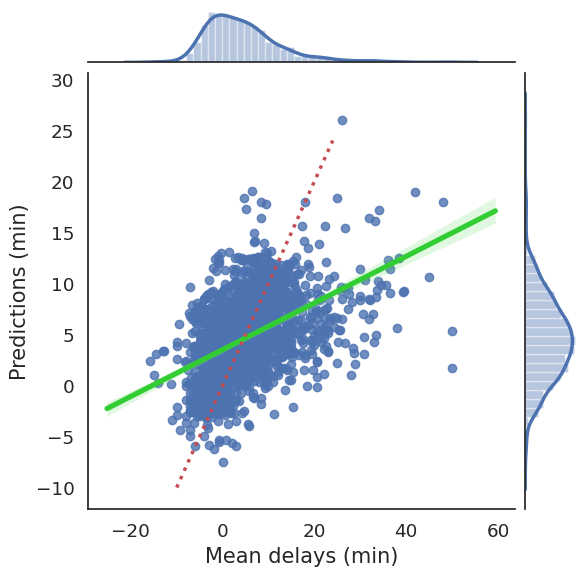

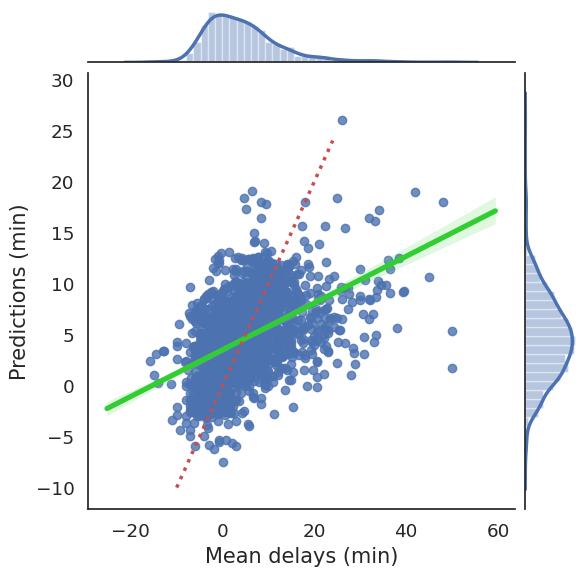

In [131]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in predictions]) 
tips["original_data"] = pd.Series([float(s) for s in Y]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
plt.show()

In [132]:
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X)
regr.fit(X_, Y)

LinearRegression()

In [133]:
result = regr.predict(X_)
print("MSE =", metrics.mean_squared_error(result, Y))

MSE = 49.503925689487794


In [134]:
icount = 0
for i, val in enumerate(Y):
    if abs(val-result[i]) > 15: icount += 1
'{:.2f}%'.format(icount / len(result) * 100)

'4.81%'

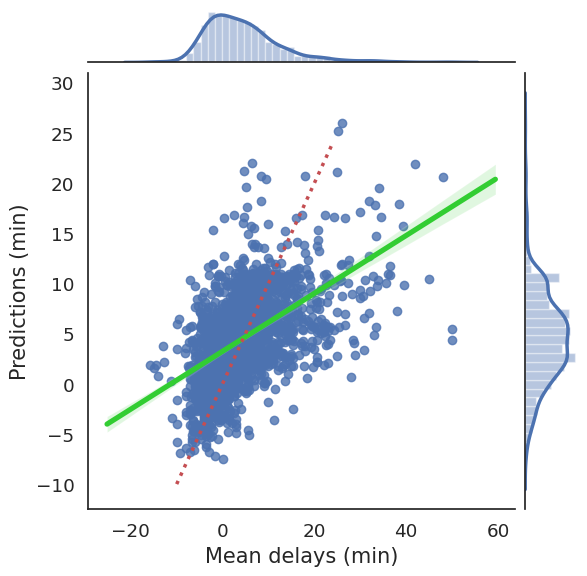

In [135]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in result]) 
tips["original_data"] = pd.Series([float(s) for s in Y]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
plt.show()

In [136]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [137]:
X_train.shape

(1281, 82)

In [138]:
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X_train)
regr.fit(X_, Y_train)
result = regr.predict(X_)
score = metrics.mean_squared_error(result, Y_train)
print("Mean squared error = ", score)

Mean squared error =  46.581451213874686


In [139]:
X_ = poly.fit_transform(X_test)
result = regr.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print("Mean squared error = ", score)

Mean squared error =  32609474.001544073


In [140]:
somme = 0
for valeurs in zip(result, Y_test):
    ajout = (float(valeurs[0]) - float(valeurs[1]))**2
    somme += ajout
    if ajout > 10**4:
        print("{:<.1f} {:<.1f} {:<.1f}".format(ajout, float(valeurs[0]), float(valeurs[1])))

5430623036.7 73700.3 7.5
12303384328.9 -110924.2 -3.6
201162609.0 14209.2 26.0


In [142]:
from sklearn.linear_model import Ridge
ridgereg = Ridge(alpha=0.3)
poly = PolynomialFeatures(degree = 2)
X_ = poly.fit_transform(X_train)
ridgereg.fit(X_, Y_train)

Ridge(alpha=0.3)

In [143]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print("Mean squared error = ", score)

Mean squared error =  129.00066682171192


In [145]:
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha = alpha/10)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)        
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)        
        if score < score_min:
            score_min = score
            parameters = [alpha/10, pol_order]
        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha, score))

n=1 alpha=0 , MSE = 6.34e+27
n=1 alpha=2 , MSE = 64.577
n=1 alpha=4 , MSE = 63.94
n=1 alpha=6 , MSE = 63.469
n=1 alpha=8 , MSE = 63.102
n=1 alpha=10 , MSE = 62.805
n=1 alpha=12 , MSE = 62.559
n=1 alpha=14 , MSE = 62.351
n=1 alpha=16 , MSE = 62.171
n=1 alpha=18 , MSE = 62.014
n=2 alpha=0 , MSE = 129.02
n=2 alpha=2 , MSE = 128.99
n=2 alpha=4 , MSE = 118.27
n=2 alpha=6 , MSE = 118.05
n=2 alpha=8 , MSE = 117.97
n=2 alpha=10 , MSE = 117.8
n=2 alpha=12 , MSE = 134.1
n=2 alpha=14 , MSE = 134.2
n=2 alpha=16 , MSE = 134.23
n=2 alpha=18 , MSE = 134.2


In [146]:
ridgereg = Ridge(alpha = parameters[0])
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)        
print(score)

53.91996874267142


In [147]:
carrier = 'AA'
merged_df_test = get_merged_delays(df_test, carrier)

In [148]:
label_conversion = dict()
for s in label_airports:
    label_conversion[s[1]] = s[0]

merged_df_test['AIRPORT__CODE'].replace(label_conversion, inplace = True)

for index, label in label_airports:
    temp = merged_df_test['AIRPORT__CODE'] == index
    temp = temp.apply(lambda x:1.0 if x else 0.0)
    if index == 0:
        matrix = np.array(temp)
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

b = np.array(merged_df_test['heure_depart_min'])
b = b.reshape(len(b),1)
X_test = np.hstack((matrix, b))
Y_test = np.array(merged_df_test['mean'])
Y_test = Y_test.reshape(len(Y_test), 1)

In [149]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
'MSE = {:.2f}'.format(score)

'MSE = 63.43'

In [150]:
'Ecart = {:.2f} min'.format(np.sqrt(score))

'Ecart = 7.96 min'

# Model nº3: Accounting for destinations

In [160]:
def create_df(df, carrier):
    df2 = df[df['AIRLINE__CODE'] == carrier][['SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL',
                                    'ORIGIN_AIRPORT_CODE','DESTINATION_AIRPORT_CODE','DEPARTURE_DELAY']]
    df2.dropna(how = 'any', inplace = True)
    df2['weekday'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.weekday())
    #____________________
    # delete delays > 1h
    df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
    df2.dropna(how = 'any', inplace = True)
    #_________________
    # formating times
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    df2['heure_depart'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    df2['heure_depart'] = df2['heure_depart'].apply(fct)
    df2['heure_arrivee'] = df2['SCHEDULED_ARRIVAL'].apply(fct)
    df3 = df2[['heure_depart', 'heure_arrivee', 'ORIGIN_AIRPORT_CODE','DEPARTURE_DELAY','weekday']]
    df3 = df3.groupby(['heure_depart', 'heure_arrivee', 'ORIGIN_AIRPORT_CODE'],
                      as_index = False).mean()
    return df3

In [161]:
df3 = create_df(df, carrier)    
df3[:5]

,heure_depart,heure_arrivee,ORIGIN_AIRPORT_CODE,DEPARTURE_DELAY,weekday
0,300,17640,LAX,2.133333,2.800000
1,300,17700,LAX,5.500000,3.750000
2,600,28200,LAX,-6.000000,3.250000
3,1200,29040,LAX,-4.117647,2.823529
4,1200,29100,LAX,0.800000,3.600000


In [162]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df3['ORIGIN_AIRPORT_CODE'])
#_________________________________________________________
zipped = zip(integer_encoded, df3['ORIGIN_AIRPORT_CODE'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
#_________________________________________________
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#_________________________________________________
b = np.array(df3[['heure_depart', 'heure_arrivee']])
X = np.hstack((onehot_encoded, b))
Y = np.array(df3['DEPARTURE_DELAY'])
Y = Y.reshape(len(Y), 1)

In [163]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [165]:
score_min = 10000
for pol_order in range(1, 3):
    for alpha in range(0, 20, 2):
        ridgereg = Ridge(alpha = alpha/10)
        poly = PolynomialFeatures(degree = pol_order)
        regr = linear_model.LinearRegression()
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)
        
        X_ = poly.fit_transform(X_test)
        result = ridgereg.predict(X_)
        score = metrics.mean_squared_error(result, Y_test)
        
        if score < score_min:
            score_min = score
            parameters = [alpha, pol_order]

        print("n={} alpha={} , MSE = {:<0.5}".format(pol_order, alpha/10, score))

n=1 alpha=0.0 , MSE = 90.747
n=1 alpha=0.2 , MSE = 90.077
n=1 alpha=0.4 , MSE = 89.614
n=1 alpha=0.6 , MSE = 89.265
n=1 alpha=0.8 , MSE = 88.989
n=1 alpha=1.0 , MSE = 88.762
n=1 alpha=1.2 , MSE = 88.57
n=1 alpha=1.4 , MSE = 88.403
n=1 alpha=1.6 , MSE = 88.256
n=1 alpha=1.8 , MSE = 88.125
n=2 alpha=0.0 , MSE = 163.06
n=2 alpha=0.2 , MSE = 163.06
n=2 alpha=0.4 , MSE = 163.06
n=2 alpha=0.6 , MSE = 163.06
n=2 alpha=0.8 , MSE = 163.06
n=2 alpha=1.0 , MSE = 163.06
n=2 alpha=1.2 , MSE = 162.71
n=2 alpha=1.4 , MSE = 162.71
n=2 alpha=1.6 , MSE = 162.71
n=2 alpha=1.8 , MSE = 162.71


In [166]:
ridgereg = Ridge(alpha = parameters[0])
poly = PolynomialFeatures(degree = parameters[1])
X_ = poly.fit_transform(X)
ridgereg.fit(X_, Y)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y)        
print(score)

78.11018958034254


In [167]:
df3 = create_df(df_test, carrier)    
df3[:5]

,heure_depart,heure_arrivee,ORIGIN_AIRPORT_CODE,DEPARTURE_DELAY,weekday
0,300,17640,LAX,-4.000,3.25
1,1200,29040,LAX,5.125,3.25
2,1800,20340,SFO,-6.750,3.25
3,2700,29340,LAS,-4.500,3.25
4,3900,31800,LAX,-4.875,3.25


In [168]:
label_conversion = dict()
for s in label_airports:
    label_conversion[s[1]] = s[0]

df3['ORIGIN_AIRPORT_CODE'].replace(label_conversion, inplace = True)

for index, label in label_airports:
    temp = df3['ORIGIN_AIRPORT_CODE'] == index
    temp = temp.apply(lambda x:1.0 if x else 0.0)
    if index == 0:
        matrix = np.array(temp)
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

b = np.array(df3[['heure_depart', 'heure_arrivee']])
X_test = np.hstack((matrix, b))
Y_test = np.array(df3['DEPARTURE_DELAY'])
Y_test = Y_test.reshape(len(Y_test), 1)

In [169]:
X_ = poly.fit_transform(X_test)
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
print('MSE = {}'.format(round(score, 2)))

MSE = 84.58


In [170]:
'Ecart = {:.2f} min'.format(np.sqrt(score))

'Ecart = 9.20 min'

In [171]:
icount = 0
for i, val in enumerate(Y_test):
    if abs(val-predictions[i]) > 15: icount += 1
print("ecarts > 15 minutes: {}%".format(round((icount / len(predictions))*100,3)))

ecarts > 15 minutes: 4.588%


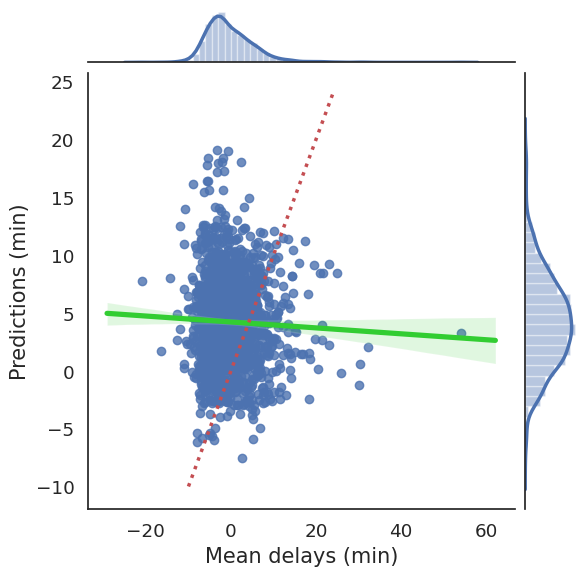

In [172]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in predictions]) 
tips["original_data"] = pd.Series([float(s) for s in Y_test]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
plt.show()